In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/raw-dataset/raw_id.csv
/kaggle/input/raw-dataset/Raw/DR/DR (29).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (41).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (18).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (17).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (7).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (13).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (39).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (27).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (43).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (9).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (35).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (22).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (2).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (42).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (49).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (33).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (21).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (37).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (5).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (50).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (45).jpg
/kaggle/input/raw-data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import shutil

2024-04-25 13:31:53.952596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 13:31:53.952796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 13:31:54.116384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv(r'/kaggle/input/dr-project/id.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'DR'
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,DR_0_61,1,DR,DR
1,DR_0_64,1,DR,DR
2,DR_0_81,1,DR,DR
3,DR_0_130,1,DR,DR
4,DR_0_137,1,DR,DR


In [4]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR    247
DR       244
Name: count, dtype: int64 

type
No_DR    53
DR       53
Name: count, dtype: int64 

type
No_DR    53
DR       53
Name: count, dtype: int64 



In [5]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [6]:
# Copy images to respective working directory
src_dir = r'/kaggle/input/dr-project/Augmented_Images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [7]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, batch_size = 32, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, batch_size = 32, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, batch_size = 32, target_size=(224,224), shuffle = False)

Found 491 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [8]:
# Get the ResNet50 base model
base_model = ResNet50(include_top=False, pooling='avg')

# Make the base model untrainable
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint(filepath='model.keras', save_best_only=True)]

In [10]:
history = model.fit(
    train_batches,
    steps_per_epoch = 100,
    validation_data = val_batches, 
    validation_steps = 100,
    epochs = 30,
    callbacks = callbacks)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - accuracy: 0.4936 - loss: 0.6973

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 676ms/step - accuracy: 0.4930 - loss: 0.7010 - val_accuracy: 0.5000 - val_loss: 0.7010
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 558ms/step - accuracy: 0.5332 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 586ms/step - accuracy: 0.5199 - loss: 0.6902 - val_accuracy: 0.5660 - val_loss: 0.6723
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 650ms/step - accuracy: 0.5958 - loss: 0.6709 - val_accuracy: 0.5283 - val_loss: 0.6736
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 625ms/step - accuracy: 0.5297 - loss: 0.6774 - val_accuracy: 0.5094 - val_loss: 0.6642
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 565ms/step - accuracy: 0.5872 - loss: 0.6658 - val_accuracy: 0.5094 - val_loss: 0.6596
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 681ms/step - accuracy: 0.6285 - loss: 0.6545 - val_accuracy: 0.5094 - val_loss: 0.6571
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 554ms/step - accuracy: 0.6043 - loss: 0.6504 - v

In [11]:
loss, accuracy = model.evaluate(val_batches)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7343 - loss: 0.5561
Loss: 0.563650906085968
Accuracy: 0.7264150977134705


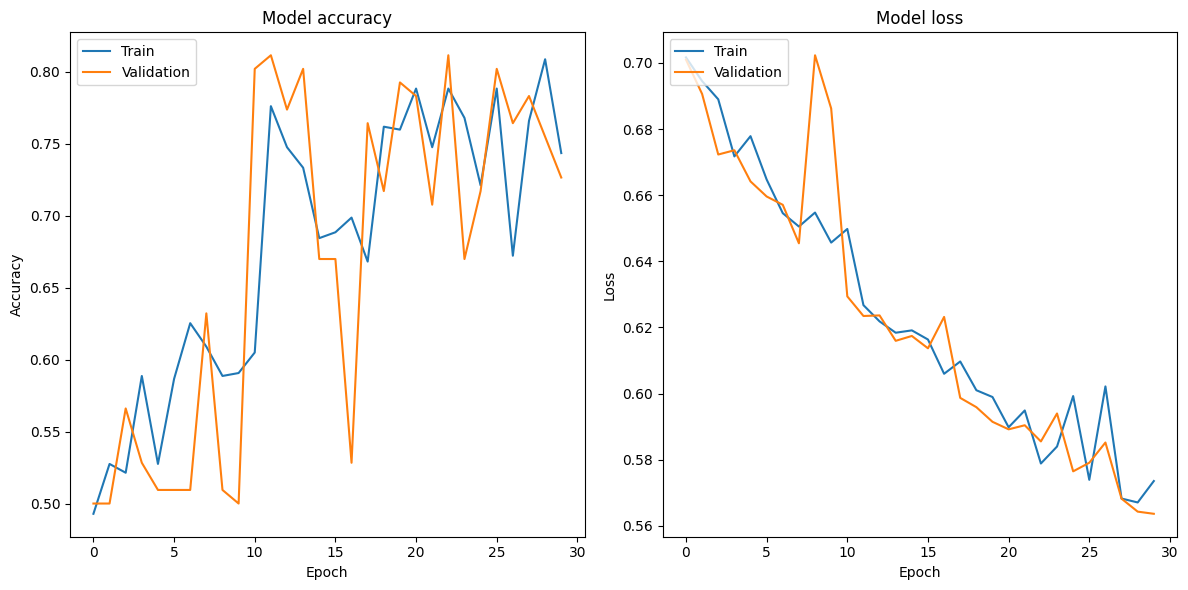

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
fname = "weights-ResNet50-DR.weights.h5"
model.save_weights(fname, overwrite = True)

In [16]:
model.save('/kaggle/working/ResNet50-DR.keras')